In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd


from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.spatial.distance import euclidean
from sklearn.neighbors import NearestNeighbors


In [2]:
class AnomalyPredictor:
    def __init__(self):
        self.model = None
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

    def create_model(self):
        model = keras.Sequential([
            keras.layers.Dense(64, activation='relu', input_shape=(2,)),  # Adjust input shape
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(2)  # Output layer: [magnetic_anomaly, gravity_anomaly]
        ])
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        self.model = model

    def train(self, X, y, epochs=50, batch_size=64):
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y)
        
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
        return history

    def predict(self, X):
        X_scaled = self.scaler_X.transform(X)
        y_pred_scaled = self.model.predict(X_scaled)
        return self.scaler_y.inverse_transform(y_pred_scaled)


In [3]:
import os
os.getcwd()
os.chdir('/Users/juanmanuelpaiba/Documents/Juan_Paiba/BairesDev/geophysical_nn_data')

In [4]:
# Read the Parquet file
file_path = 'Data/Outputs/nn_data.gzip.parquet'
df = pd.read_parquet(file_path, engine='pyarrow')

In [5]:
print(df.shape)
df.head()

(2610615, 4)


,latitude,longitude,grav_anom,Magnetic_Anomaly_mGal
0,71.98,0.02,1258.8,0.264106
1,71.98,0.12,1233.2,0.193864
2,71.98,0.58,1131.3,-1.882204
3,71.98,0.95,1361.6,-0.242788
4,71.98,1.32,257.3,-0.686848


In [6]:
# Create a smaller sample
sample_size = 20000  # Adjust this number as needed
df_sample = df.sample(n=sample_size, random_state=42)

In [7]:
# Define X and y
X = df_sample[['latitude', 'longitude']]
y = df_sample[['grav_anom','Magnetic_Anomaly_mGal']]

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Create and train the model
predictor = AnomalyPredictor()
predictor.create_model()
history = predictor.train(X, y, epochs=50, batch_size=64)

Epoch 1/50
219/219 [==============================] - 0s 1ms/step - loss: 1.0067 - mae: 0.6362 - val_loss: 1.0007 - val_mae: 0.6431
Epoch 2/50
219/219 [==============================] - 0s 1ms/step - loss: 1.0010 - mae: 0.6343 - val_loss: 0.9998 - val_mae: 0.6464
Epoch 3/50
219/219 [==============================] - 0s 762us/step - loss: 1.0004 - mae: 0.6342 - val_loss: 1.0001 - val_mae: 0.6497
Epoch 4/50
219/219 [==============================] - 0s 763us/step - loss: 1.0003 - mae: 0.6343 - val_loss: 1.0000 - val_mae: 0.6472
Epoch 5/50
219/219 [==============================] - 0s 762us/step - loss: 1.0003 - mae: 0.6346 - val_loss: 1.0008 - val_mae: 0.6427
Epoch 6/50
219/219 [==============================] - 0s 749us/step - loss: 1.0002 - mae: 0.6348 - val_loss: 1.0000 - val_mae: 0.6475
Epoch 7/50
219/219 [==============================] - 0s 772us/step - loss: 1.0001 - mae: 0.6345 - val_loss: 1.0004 - val_mae: 0.6455
Epoch 8/50
219/219 [==============================] - 0s 756us/ste

In [10]:
X_test.head()

,latitude,longitude
1601602,-16.18,165.68
2211711,-49.95,152.02
1347392,-2.22,91.35
1055967,14.02,209.82
1177803,7.38,175.65


In [11]:
X_test_scaled = StandardScaler().fit_transform(X_test)

In [12]:
# Make predictions using the subset
y_pred = predictor.predict(X_test_scaled)

125/125 [==============================] - 0s 376us/step


/Users/juanmanuelpaiba/.pyenv/versions/3.8.17/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [13]:
# Calculate Mean Absolute Error (MAE) for Magnetic_Anomaly_mGal
mae_mag = mean_absolute_error(y_test['Magnetic_Anomaly_mGal'], y_pred[:, 1])

# Calculate Mean Squared Error (MSE) for Magnetic_Anomaly_mGal
mse_mag = mean_squared_error(y_test['Magnetic_Anomaly_mGal'], y_pred[:, 1])

# Calculate Root Mean Squared Error (RMSE) for Magnetic_Anomaly_mGal
rmse_mag = np.sqrt(mse_mag)

print(f'Magnetic Anomaly - Mean Absolute Error (MAE): {mae_mag}')
print(f'Magnetic Anomaly - Mean Squared Error (MSE): {mse_mag}')
print(f'Magnetic Anomaly - Root Mean Squared Error (RMSE): {rmse_mag}')

Magnetic Anomaly - Mean Absolute Error (MAE): 0.5684386780029245
Magnetic Anomaly - Mean Squared Error (MSE): 0.8159254816657895
Magnetic Anomaly - Root Mean Squared Error (RMSE): 0.9032859357179152


In [14]:
# Calculate Mean Absolute Error (MAE) for grav_anom
mae_grav = mean_absolute_error(y_test['grav_anom'], y_pred[:, 0])

# Calculate Mean Squared Error (MSE) for grav_anom
mse_grav = mean_squared_error(y_test['grav_anom'], y_pred[:, 0])

# Calculate Root Mean Squared Error (RMSE) for grav_anom
rmse_grav = np.sqrt(mse_grav)

print(f'Gravity Anomaly - Mean Absolute Error (MAE): {mae_grav}')
print(f'Gravity Anomaly - Mean Squared Error (MSE): {mse_grav}')
print(f'Gravity Anomaly - Root Mean Squared Error (RMSE): {rmse_grav}')

Gravity Anomaly - Mean Absolute Error (MAE): 236.96282662963873
Gravity Anomaly - Mean Squared Error (MSE): 127795.49726191729
Gravity Anomaly - Root Mean Squared Error (RMSE): 357.4849608891503


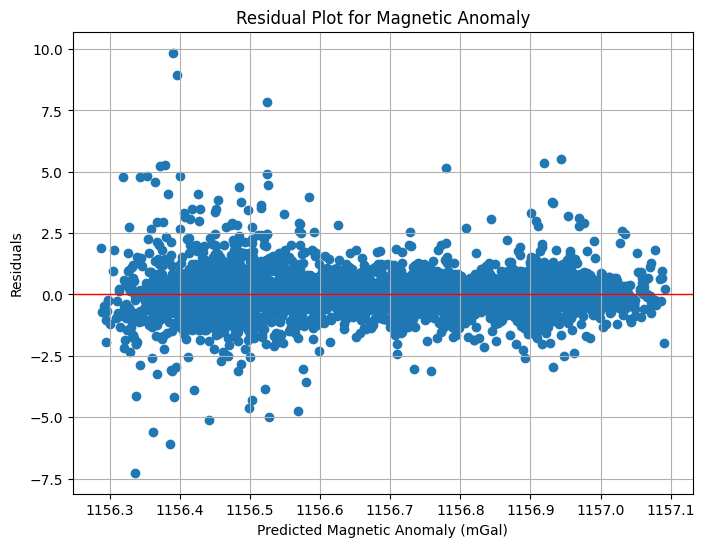

In [15]:
# Calculate residuals for Magnetic_Anomaly_mGal
residuals_mag = y_test['Magnetic_Anomaly_mGal'] - y_pred[:, 1]

# Plot residuals against predicted values for Magnetic_Anomaly_mGal
plt.figure(figsize=(8, 6))
plt.scatter(y_pred[:, 0], residuals_mag)
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.xlabel('Predicted Magnetic Anomaly (mGal)')
plt.ylabel('Residuals')
plt.title('Residual Plot for Magnetic Anomaly')
plt.grid(True)
plt.show()

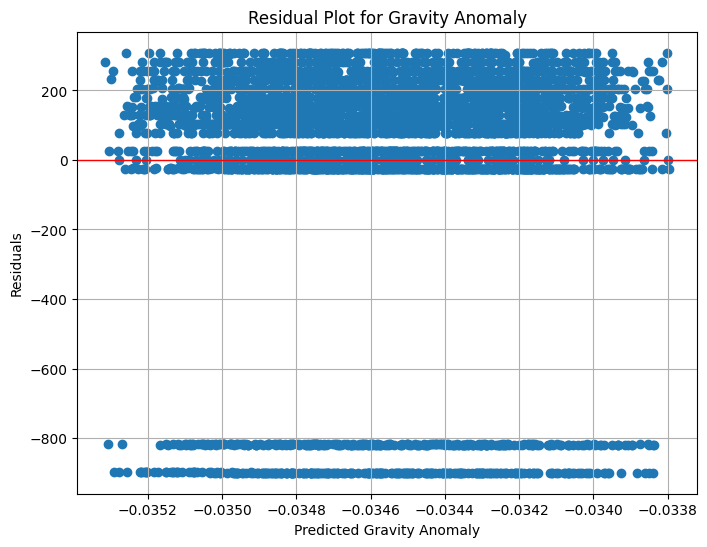

In [16]:
# Calculate residuals for grav_anom
residuals_grav = y_test['grav_anom'] - y_pred[:, 0]

# Plot residuals against predicted values for grav_anom
plt.figure(figsize=(8, 6))
plt.scatter(y_pred[:, 1], residuals_grav)
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.xlabel('Predicted Gravity Anomaly')
plt.ylabel('Residuals')
plt.title('Residual Plot for Gravity Anomaly')
plt.grid(True)
plt.show()

In [38]:
class MultiDimensionalVAP:
    def __init__(self, dataframe):
        self.data = dataframe
        self.nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(self.data[['latitude', 'longitude']])
    
    def add_vap(self, latitude, longitude, grav_anom, Magnetic_Anomaly_mGal):
        new_vap = pd.DataFrame({
            'latitude': [latitude],
            'longitude': [longitude],
            'grav_anom': [grav_anom],
            #'elevation': [elevation],
            'Magnetic_Anomaly_mGal': [Magnetic_Anomaly_mGal]
            
          #  'pressure': [pressure]
        })
        self.data = pd.concat([self.data, new_vap], ignore_index=True)
        self.nbrs.fit(self.data[['latitude', 'longitude']])
    
    def find_nearest_vaps(self, latitude, longitude, num_vaps=3):
        distances, indices = self.nbrs.kneighbors([[latitude, longitude]], n_neighbors=num_vaps)
        return self.data.iloc[indices[0]]
    
    def interpolate_position(self, vaps, **kwargs):
        """
        Interpolates the position based on given readings.
        
        Parameters:
        vaps (pd.DataFrame): DataFrame containing VAPs data.
        **kwargs: Arbitrary keyword arguments containing latitude, longitude,
                  magnetic_reading, gravity_reading.
        
        Returns:
        dict: A dictionary containing the interpolated position and readings.
        """
        # Retrieve values from kwargs
        latitude = kwargs.get('latitude', None)
        longitude = kwargs.get('longitude', None)
        gravity_reading = kwargs.get('grav_anom', None)
        magnetic_reading = kwargs.get('Magnetic_Anomaly_mGal', None)
        
        
        if latitude is None or longitude is None:
            raise ValueError("Latitude and longitude must be provided.")
        
        # Calculate weights based on inverse distance
        distances = vaps.apply(lambda row: euclidean((row['latitude'], row['longitude']), (latitude, longitude)), axis=1)
        weights = 1 / distances
        weights /= weights.sum()  # Normalize weights to sum to 1
        
        # Perform weighted average interpolation for latitude and longitude
        interpolated_latitude = np.sum(weights * vaps['latitude'])
        interpolated_longitude = np.sum(weights * vaps['longitude'])
        
        # For elevation, you can implement interpolation logic here if elevation data is available
        
        # Return interpolated values along with provided readings
        return {
            'latitude': interpolated_latitude,
            'longitude': interpolated_longitude,
            'gravity_anomaly': gravity_reading,
            'magnetic_field': magnetic_reading
        }

In [64]:
class EnhancedMultiDimensionalVAP(MultiDimensionalVAP):
    def __init__(self, db_path):
        super().__init__(db_path)
        self.anomaly_predictor = AnomalyPredictor()
        self.train_predictor()

    def train_predictor(self):
        # Fetch all VAP data
        #self.cursor.execute('SELECT latitude, longitude, magnetic_anomaly, gravity_anomaly FROM multi_vaps')
        data = self.data[['latitude', 'longitude', 'grav_anom','Magnetic_Anomaly_mGal']]
        X = data[['latitude', 'longitude']].values
        y = data[['grav_anom','Magnetic_Anomaly_mGal']].values
        
        self.anomaly_predictor.create_model()
        self.anomaly_predictor.train(X, y)

    def predict_anomalies(self, lat, lon):
        X = np.array([[lat, lon]])
        y_pred = self.anomaly_predictor.predict(X)
        return y_pred[0]
        
    def interpolate_position(self, vaps, latitude=None, longitude=None, gravity_reading=None, magnetic_reading=None):
        if latitude is None or longitude is None:
            raise ValueError("Latitude and longitude must be provided.")

        if len(vaps) < 3:  # If we have very sparse data
            # Predict anomalies for the current location
            predicted_anomalies = self.predict_anomalies(latitude, longitude)

            # Create a DataFrame with the new row
            new_row = pd.DataFrame({
                'latitude': [latitude],
                'longitude': [longitude],
                'grav_anom': [predicted_anomalies[0]],
                'Magnetic_Anomaly_mGal': [predicted_anomalies[1]],
            })

            # Combine the original DataFrame with the new row
            combined_vaps = pd.concat([vaps, new_row], ignore_index=True)

            return super().interpolate_position(combined_vaps, gravity_reading, magnetic_reading)
        else:
            # Calculate weights based on inverse distance
            distances = vaps.apply(lambda row: euclidean((row['latitude'], row['longitude']), (latitude, longitude)), axis=1)
            weights = 1 / distances
            weights /= weights.sum()  # Normalize weights to sum to 1
            
            # Perform weighted average interpolation for latitude and longitude
            interpolated_latitude = np.sum(weights * vaps['latitude'])
            interpolated_longitude = np.sum(weights * vaps['longitude'])
            
            # For gravity and magnetic fields, take the average (or apply custom logic as needed)
            interpolated_gravity_anomaly = np.mean(vaps['grav_anom'])
            interpolated_magnetic_field = np.mean(vaps['Magnetic_Anomaly_mGal'])

            # Return interpolated values along with provided readings
            return {
                'latitude': interpolated_latitude,
                'longitude': interpolated_longitude,
                'gravity_anomaly': interpolated_gravity_anomaly,
                'magnetic_field': interpolated_magnetic_field,
            }
        
    def calculate_confidence(self, vaps, gravity_reading, magnetic_reading):
        """
        Calculate the confidence of the interpolation based on the VAPs data and the readings.

        Parameters:
        vaps (pd.DataFrame): DataFrame containing VAPs data.
        magnetic_reading (float): Magnetic field reading.
        gravity_reading (float): Gravity anomaly reading.

        Returns:
        float: Confidence value (0 to 1).
        """
        if len(vaps) < 2:
            return 0.5  # If less than 2 VAPs, return a low confidence by default

        # Calculate distance-based confidence
        lat_mean = vaps['latitude'].mean()
        lon_mean = vaps['longitude'].mean()
        distances = np.sqrt((vaps['latitude'] - lat_mean)**2 + (vaps['longitude'] - lon_mean)**2)
        distance_confidence = 1 - np.mean(distances)  # Closer VAPs give higher confidence

        # Calculate reading variance-based confidence
        magnetic_variance = vaps['Magnetic_Anomaly_mGal'].var()
        gravity_variance = vaps['grav_anom'].var()
        reading_variance = (magnetic_variance + gravity_variance) / 3
        reading_confidence = 1 / (1 + reading_variance)  # Lower variance gives higher confidence

        # Combine both confidences
        combined_confidence = (distance_confidence + reading_confidence) / 2

        # Ensure confidence is between 0 and 1
        return max(0, min(1, combined_confidence))


In [65]:
X_test

,latitude,longitude
1601602,-16.18,165.68
2211711,-49.95,152.02
1347392,-2.22,91.35
1055967,14.02,209.82
1177803,7.38,175.65
...,...,...
1008345,16.68,41.85
2296584,-54.72,207.05
891887,23.68,285.08
1974189,-36.42,307.52


In [66]:
# Usage example
vap_system = EnhancedMultiDimensionalVAP(df_sample)

Epoch 1/50
219/219 [==============================] - 0s 1ms/step - loss: 1.0026 - mae: 0.6348 - val_loss: 0.9998 - val_mae: 0.6454
Epoch 2/50
219/219 [==============================] - 0s 846us/step - loss: 1.0003 - mae: 0.6344 - val_loss: 0.9994 - val_mae: 0.6496
Epoch 3/50
219/219 [==============================] - 0s 1ms/step - loss: 0.9998 - mae: 0.6332 - val_loss: 0.9995 - val_mae: 0.6469
Epoch 4/50
219/219 [==============================] - 0s 1ms/step - loss: 0.9998 - mae: 0.6344 - val_loss: 0.9998 - val_mae: 0.6462
Epoch 5/50
219/219 [==============================] - 0s 1ms/step - loss: 0.9994 - mae: 0.6340 - val_loss: 1.0000 - val_mae: 0.6439
Epoch 6/50
219/219 [==============================] - 0s 973us/step - loss: 0.9995 - mae: 0.6344 - val_loss: 1.0005 - val_mae: 0.6458
Epoch 7/50
219/219 [==============================] - 0s 878us/step - loss: 0.9996 - mae: 0.6323 - val_loss: 0.9997 - val_mae: 0.6454
Epoch 8/50
219/219 [==============================] - 0s 1ms/step - lo

In [67]:
# Add some sample VAPs (this would typically be done with real data)
vap_system.add_vap(-33.98, 140.38, 1481.0, 0.097864)
vap_system.add_vap(28.15, 60.42, 1301.7, -0.785708)

In [68]:
# Find nearest VAPs
nearest_vaps = vap_system.find_nearest_vaps(-4.5, 272.4196, num_vaps=2) 

/Users/juanmanuelpaiba/.pyenv/versions/3.8.17/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [69]:
# Step 1: Find nearest VAPs
nearest_vaps = vap_system.find_nearest_vaps(-4.5, 272.4196, num_vaps=3)

/Users/juanmanuelpaiba/.pyenv/versions/3.8.17/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [70]:
nearest_vaps

,latitude,longitude,grav_anom,Magnetic_Anomaly_mGal
1373,-4.05,272.15,257.3,-0.722446
12931,-4.85,273.72,1412.5,-1.049381
2932,-5.42,271.32,1156.4,0.136078


In [71]:
# Example usage with keyword arguments
estimated_position = vap_system.interpolate_position(
    nearest_vaps,
    latitude=-4.5,
    longitude=272.4196
)

print(estimated_position)

{'latitude': -4.513077619099756, 'longitude': 272.325389461208, 'gravity_anomaly': 942.0666666666666, 'magnetic_field': -0.5452494543172047}


In [72]:
# Calculate confidence
confidence = vap_system.calculate_confidence(nearest_vaps, 1000, -0.6)

In [74]:
print(f"Estimated position: {estimated_position}")
print(f"Confidence: {confidence}")

# Predict anomalies for a new location
predicted_anomalies = vap_system.predict_anomalies(37.7752, -122.4197)
print(f"Predicted anomalies: Magnetic = {predicted_anomalies[0]}, Gravity = {predicted_anomalies[1]}")

Estimated position: {'latitude': -4.513077619099756, 'longitude': 272.325389461208, 'gravity_anomaly': 942.0666666666666, 'magnetic_field': -0.5452494543172047}
Confidence: 0
1/1 [==============================] - 0s 30ms/step
Predicted anomalies: Magnetic = 1174.8128662109375, Gravity = 0.06276611238718033
